# **P**redicting **A**ccurate **S**pectral **T**races for **A**strophysical **SOSS** Spectra Demo (WORK IN PROGRESS)
----
This notebook demos how to use the `PASTASOSS` package to rapidly generate the trace positions for NIRISS/SOSS observations, in addition we include and example SOSS observation. `PASTASOSS` uses reference models of trace positions for commanded position of the GR700XD, for order 1 and 2. We apply a rotation transform to reference models to derive the trace positions for any given pupil wheel position angle that is included in the FITS header using the keyword `PWCPOS`. The associate wavelength for each trace positions will be added to the tool at a later date to provide a complete picture with sub-pixel performance. Future iterations of this will include update models for spectral traces positions and will eventually include support for order 3. 


#### About this Notebook
**_Author_**: Tyler Baines, STScI Science Support Analyst 

email: <tbaines@stsci.edu>

**_Date Updated_**: 5/10/2023

**_Observatory_**: JWST

**_Instrument/Mode_**: NIRISS/SOSS



## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pastasoss

## Generate Trace Positions

First's, load in an example image that has been provided for this notebook and the pupil wheel position associated with the SOSS observation has been given. We will demonstratte how to use `PASTASOSS` to generate the trace positions for this observation given the pupil wheel position.

The example SOSS observation used in this demo is from the calibration program 1512 dataset. 

Let's begin by loading in the image for this demo:

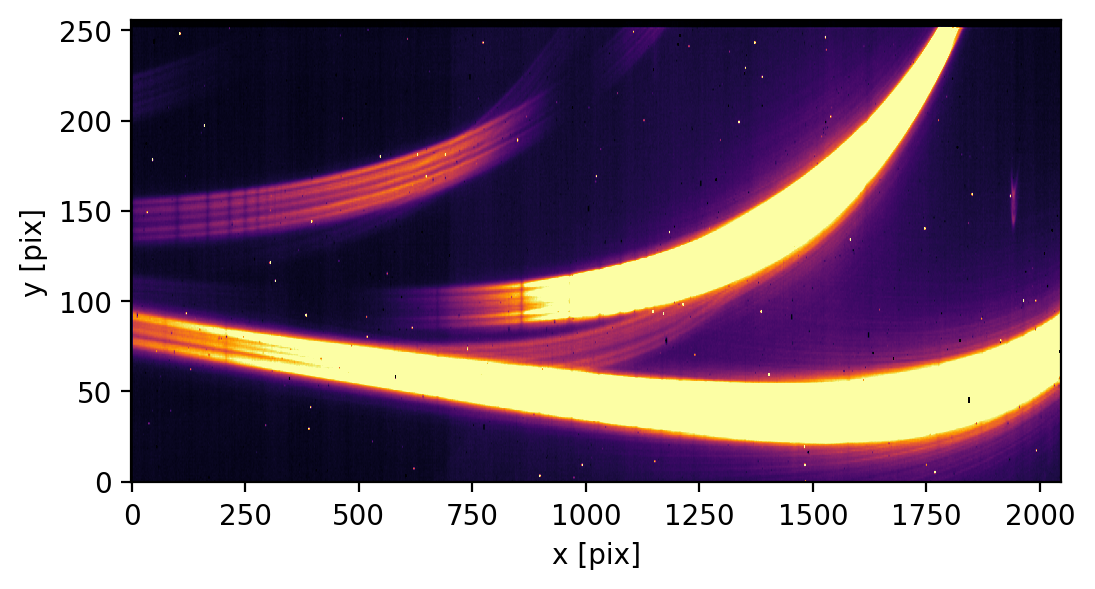

In [2]:
# Load the .npy file containing only the image.
data = np.load('jw01512001001_03102_00001_nis_demo_pwcpos_245.778671.npy')

# Pupil wheel position assocaitated with the example observation. 
pwcpos = 245.778671

# Plot the image
plt.figure(figsize=(6,3), dpi=200)
plt.imshow(data, vmin=0, vmax=50, origin='lower', aspect='auto',cmap='inferno')
plt.xlabel('x [pix]')
plt.ylabel('y [pix]')
plt.show()


Next, will we generate the trace positions for spectral orders 1 and 2 using the `get_trace_from_reference_transform` function from `PASTASOSS`.

In [3]:
traces_order1 = pastasoss.get_soss_traces(pwcpos=pwcpos, order='1', interp=True) 
traces_order2 = pastasoss.get_soss_traces(pwcpos=pwcpos, order='2', interp=True)

You can also called the function in a single line by the follow:

In [4]:
# uncomment this line and run the cell
# traces_order1, traces_order2 = pastasoss.get_trace_from_reference_transform(pwcpos=pwcpos, order='12', interp=True)

Next, lets plot our traces we just generated for this observation ontop of our image. Let separate our traces into their x-,y-compenents.

In [5]:
x1, y1 = traces_order1
x2, y2, = traces_order2

Now lets plots traces for orders 1 and 2 on top of our example SOSS observations

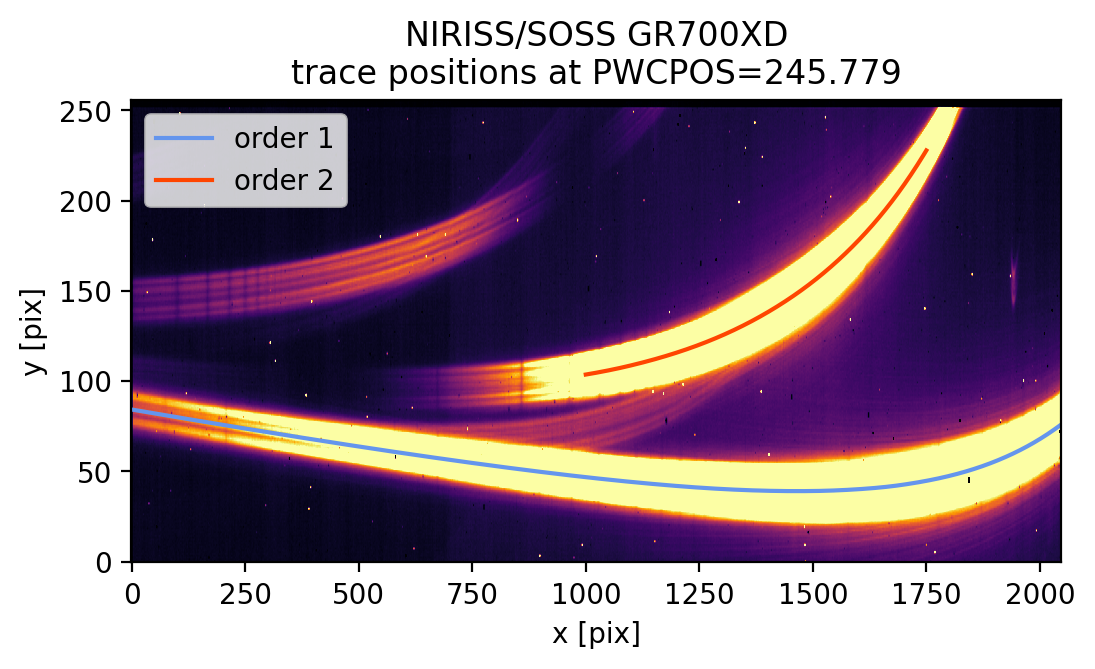

In [6]:
plt.figure(figsize=(6,3), dpi=200)
plt.title(f'NIRISS/SOSS GR700XD\ntrace positions at PWCPOS={pwcpos:.3f}')
plt.imshow(data, vmin=0, vmax=50, origin='lower', aspect='auto', cmap='inferno')
plt.plot(x1,y1, lw=1.5, label=f'order 1', color='cornflowerblue')
plt.plot(x2,y2, lw=1.5, label=f'order 2', color='orangered')
plt.xlabel('x [pix]')
plt.ylabel('y [pix]')
plt.legend()
plt.show()

Now that we have our traces positions for spectral order 1 and 2, we can perform a simple aperutre extraction to extract the spectrum.  

In [7]:
# ignore values less zero
data[data<0] = 0

# Define how many pixels we want to set our aperture above and below the trace center
npix = 15

# perform a simple aperture extraction
flux_order1 = [data[int(y)-npix:int(y)+npix, int(x)].sum() for x, y in zip(x1, y1)]
flux_order2 = [data[int(y)-npix:int(y)+npix, int(x)].sum() for x, y in zip(x2, y2)]

Let's plot the extracted spectrum for orders 1 and 2.

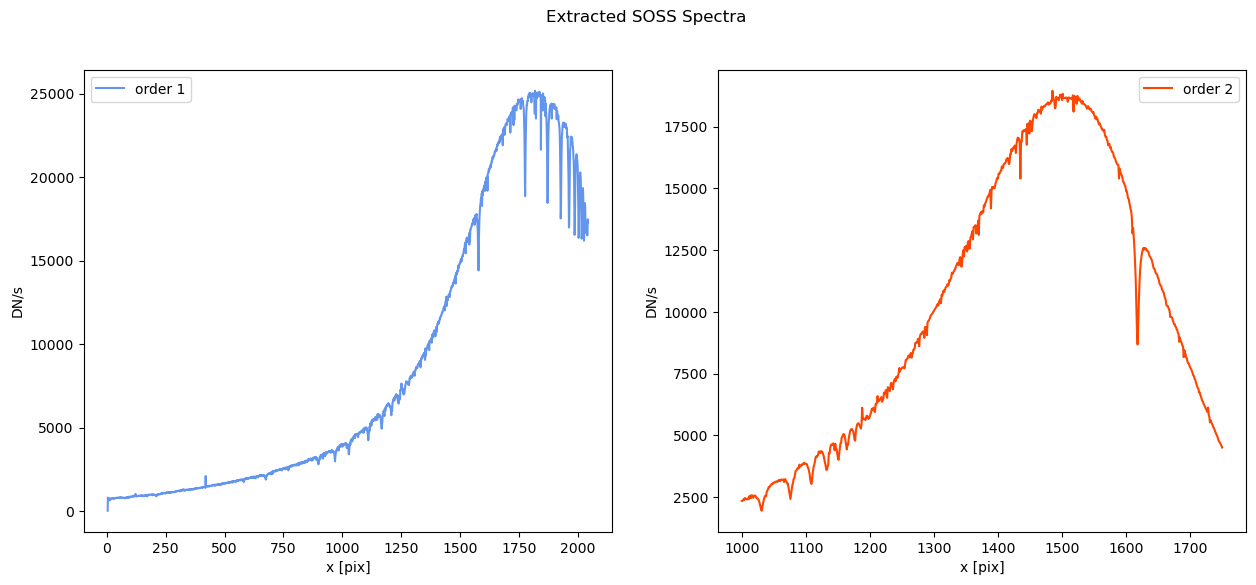

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Extracted SOSS Spectra')
ax1.plot(x1, flux_order1, lw=1.5, label=f'order 1', color='cornflowerblue')
ax1.set_xlabel('x [pix]')
ax1.set_ylabel('DN/s')
ax1.legend()

ax2.plot(x2, flux_order2, lw=1.5, label=f'order 2', color='orangered')
ax2.set_xlabel('x [pix]')
ax2.set_ylabel('DN/s')
ax2.legend()
plt.show()

# Conclusion

This concludes the demo of how to use the PASATSOSS Package.

Future updates to the package will include:
- support for order 3 traces
- including a wavelength solution model that predicts the assocated wavelengths for the traces positions given the pupil wheel position

If you use this tool in your work, please cite the tool and author(s). For questions about the tool or interesting in contributing to the package please contact the author. 